In [1]:
### imports

import keras
import numpy as np
import pandas as pd
from scipy import stats
from keras.models import Model
from keras.layers import Input, Dense, BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import uproot
import awkward as ak
from tqdm.notebook import tqdm

In [2]:
# latex settings block

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
    "xtick.labelsize": 18,
    "ytick.labelsize": 18,
    "legend.numpoints": 1,
    "axes.linewidth": 2,
    "legend.title_fontsize": 18,
    "axes.labelsize": 18,
    "legend.fontsize": 16
})

In [3]:
with np.load("root_files/combined_train.npz") as file:
    feature_array = file['features']
    label_array = file['labels']
    features = file['names'].tolist()
    
nfeatures = len(features)
nlabels = 2

In [4]:
df = pd.DataFrame(feature_array, columns=features)
bkg = df[label_array[:,0]==1]
sig = df[label_array[:,1]==1]

In [5]:
del feature_array, label_array

In [7]:
with np.load("root_files/combined_test.npz") as file:
    feature_array_test = file['features']
    label_array_test = file['labels']

In [8]:
df_test = pd.DataFrame(feature_array_test, columns=features)
bkg_test = df_test[label_array_test[:,0]==1]
sig_test = df_test[label_array_test[:,1]==1]

In [9]:
del feature_array_test, label_array_test

In [10]:
sig_train_out = sig
bkg_train_out = bkg
sig_test_out = sig_test
bkg_test_out = bkg_test

In [11]:
print(bkg.shape)
print(bkg_train_out.shape)
print(bkg_test.shape)
print(bkg_test_out.shape)

(11734326, 49)
(11734326, 49)
(1467277, 49)
(1467277, 49)


In [12]:
del bkg, sig, bkg_test, sig_test, df

In [13]:
bkg_train_out = bkg_train_out.sample(len(sig_train_out)).reset_index(drop=True)
bkg_test_out = bkg_test_out.sample(len(sig_test_out)).reset_index(drop=True)

In [14]:
print(bkg_train_out.shape)
print(sig_train_out.shape)
print(bkg_test_out.shape)
print(sig_test_out.shape)

(1782913, 49)
(1782913, 49)
(222732, 49)
(222732, 49)


  0%|          | 0/48 [00:00<?, ?it/s]

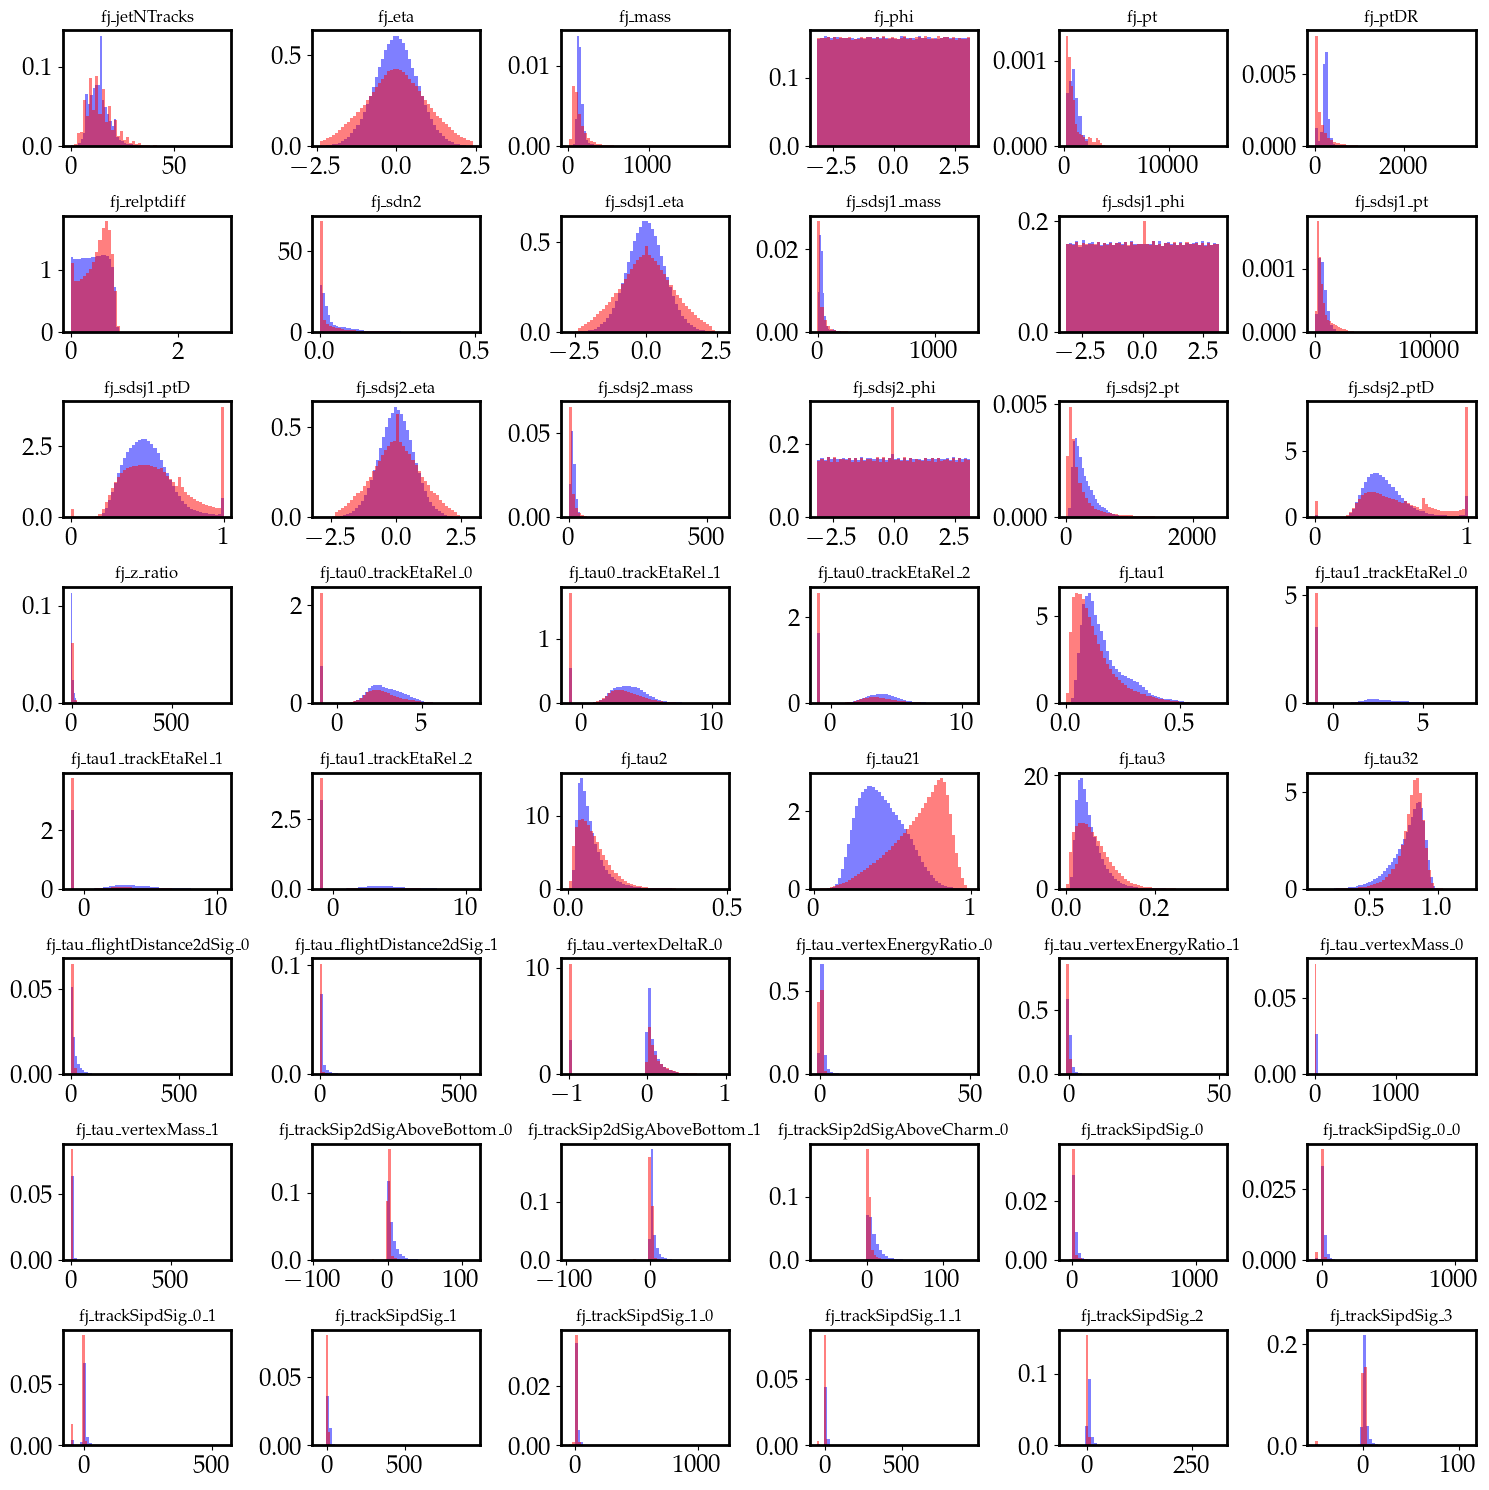

In [20]:
fig, axes = plt.subplots(8,6, figsize=(15,15))

features_to_plot = sig_train_out.columns.drop('fj_nSV')

for ax, label in tqdm(zip(axes.ravel(), features_to_plot), total = len(features_to_plot)):
    ax.hist(sig_train_out[label],density=True,color='b',alpha=0.5,bins=50)
    ax.hist(bkg_train_out[label],density=True,color='r',alpha=0.5,bins=50)
    ax.set_title(label)

plt.tight_layout()
plt.show()

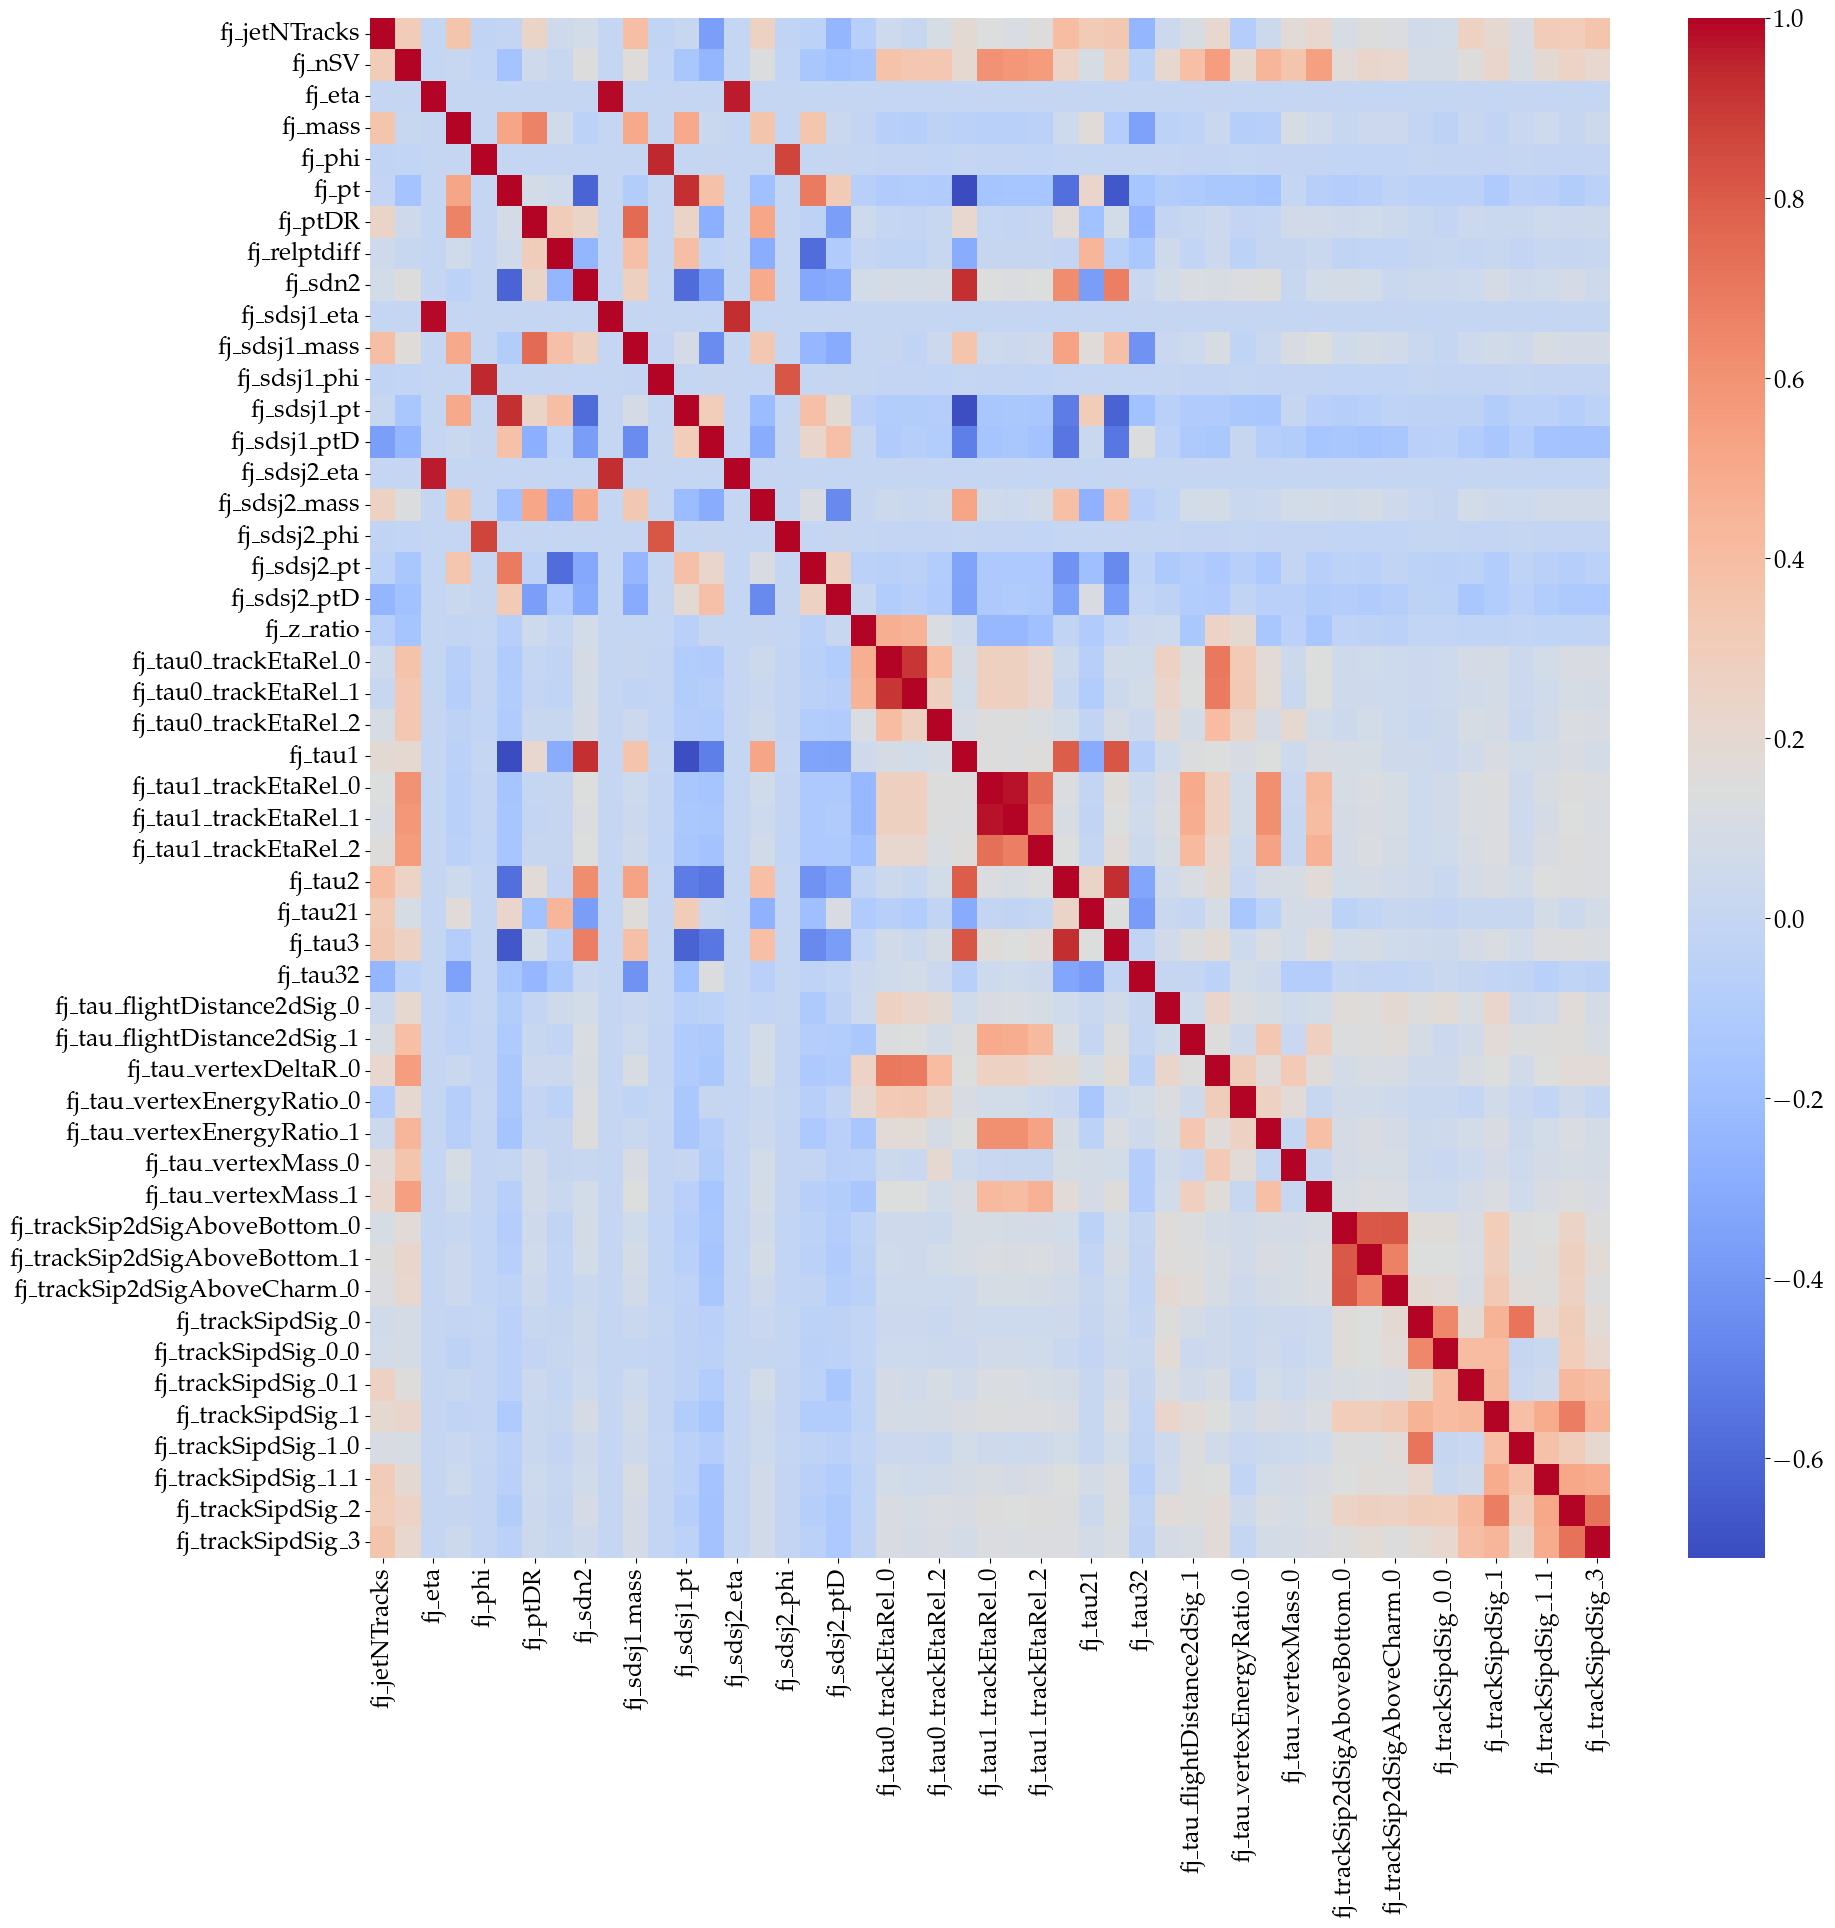

In [26]:
plt.figure(figsize=(20,20))
sns.heatmap(sig_train_out.corr(), cmap='coolwarm',annot=False, fmt='.2f')
plt.show()

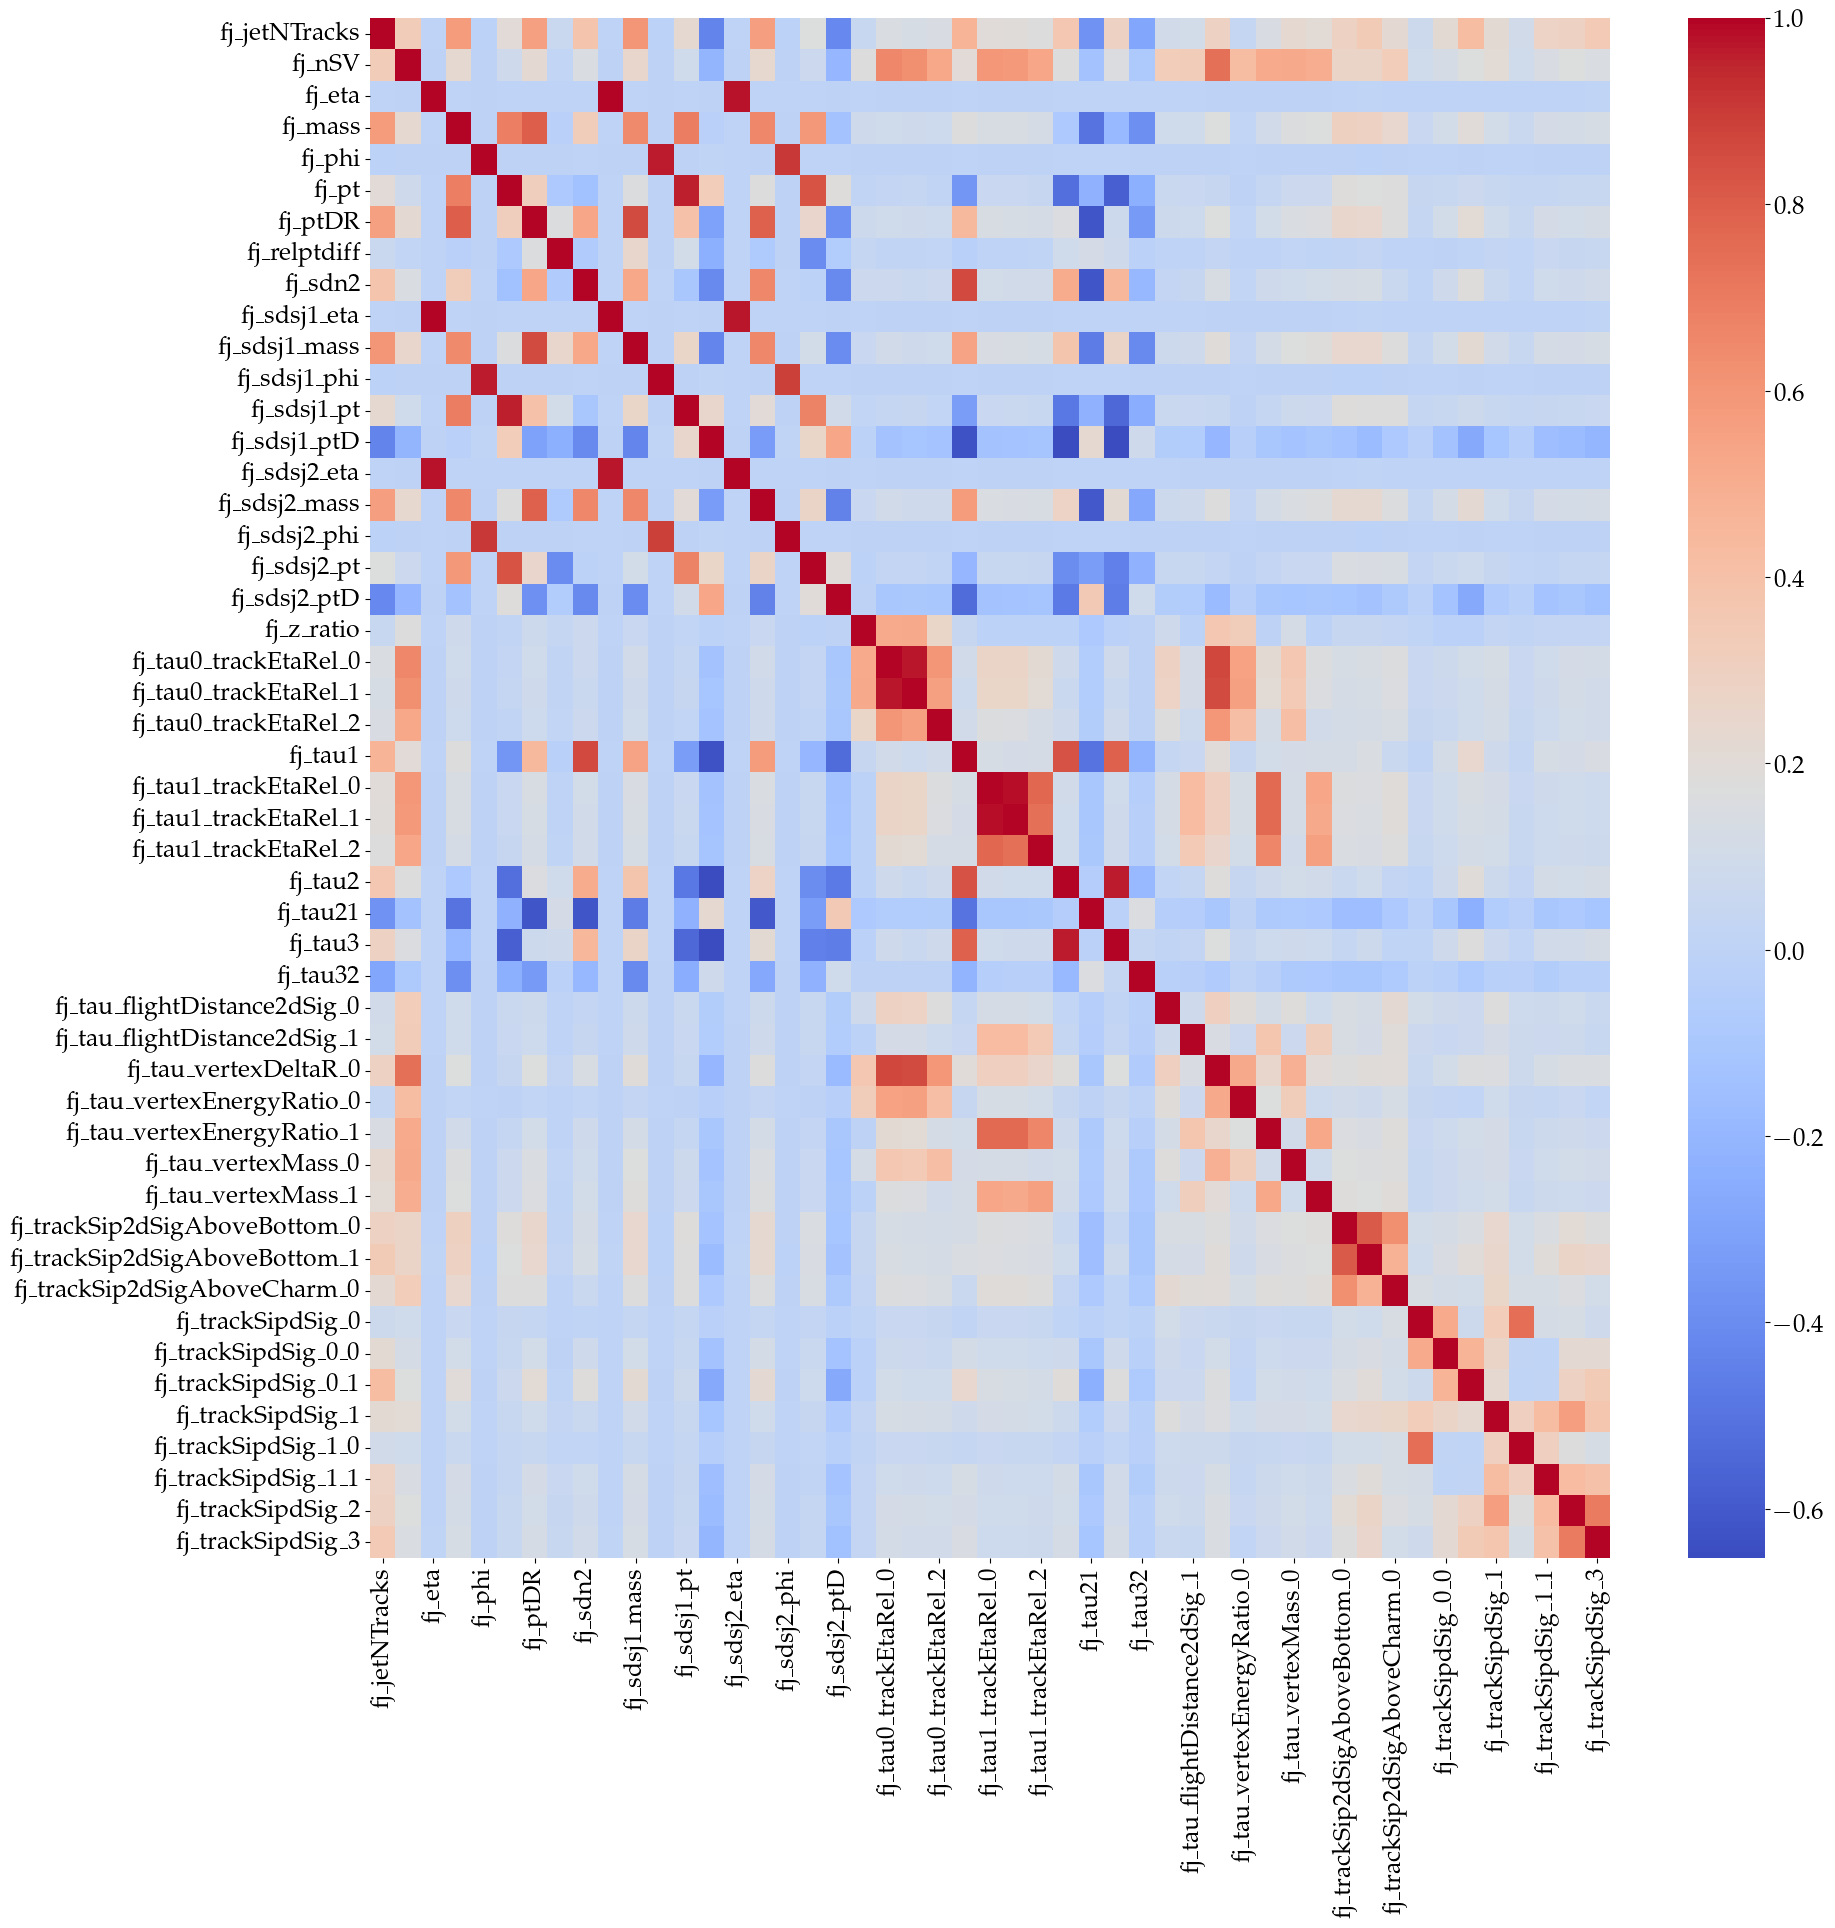

In [27]:
plt.figure(figsize=(20,20))
sns.heatmap(bkg_train_out.corr(), cmap='coolwarm',annot=False, fmt='.2f')
plt.show()

In [28]:
hbb = np.concatenate((np.ones(len(sig_train_out)),np.zeros(len(bkg_train_out))), axis=None)
QCD = np.concatenate((np.zeros(len(sig_train_out)),np.ones(len(bkg_train_out))), axis=None)
traindata = pd.concat([sig_train_out, bkg_train_out])
traindata['hbb'] = hbb
traindata['QCD'] = QCD

train = traindata.sample(frac=1).reset_index(drop=True)
X_train = train.iloc[:,:-2]
y_train = train.iloc[:,-2:]

In [29]:
del traindata

In [30]:
hbb = np.concatenate((np.ones(len(sig_test_out)),np.zeros(len(bkg_test_out))), axis=None)
QCD = np.concatenate((np.zeros(len(sig_test_out)),np.ones(len(bkg_test_out))), axis=None)
testdata = pd.concat([sig_test_out, bkg_test_out])
testdata['hbb'] = hbb
testdata['QCD'] = QCD

test = testdata.sample(frac=1).reset_index(drop=True)
X_test = test.iloc[:,:-2]
y_test = test.iloc[:,-2:]

In [31]:
del testdata

In [32]:
%%time
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_train = pd.DataFrame(X_train)

X_test = scaler.transform(X_test)
X_test = pd.DataFrame(X_test)

CPU times: user 560 ms, sys: 267 ms, total: 827 ms
Wall time: 824 ms


In [33]:
eigenvalues, eigenvectors = np.linalg.eig(X_train.cov())

In [34]:
idx = eigenvalues.argsort()[::-1]   
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:,idx]

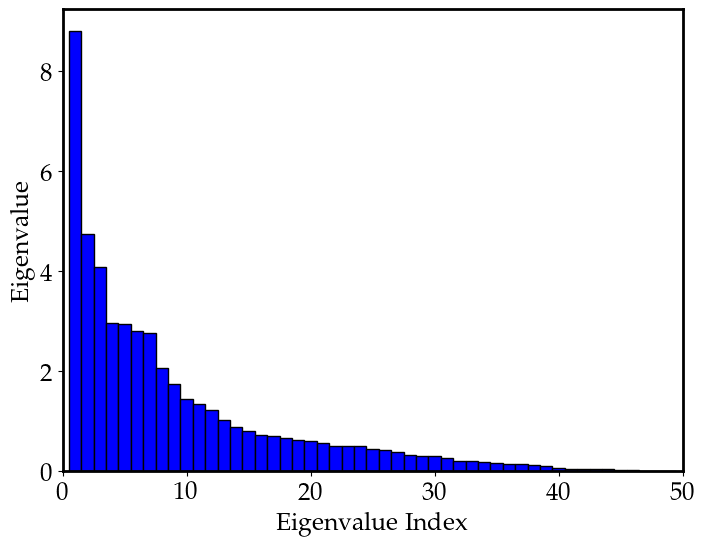

In [35]:
plt.figure(figsize=(8,6))
x = np.arange(1,nfeatures+1)
plt.xlim(0,nfeatures+1)
plt.bar(x,eigenvalues,color='b',width=1,edgecolor='k')
plt.xlabel('Eigenvalue Index')
plt.ylabel('Eigenvalue')
plt.show()

In [36]:
%%time
pca = PCA()
pca.fit(X_train)
print(pca.explained_variance_ratio_)
print(np.cumsum(pca.explained_variance_ratio_))
print(pca.singular_values_)

[1.79724681e-01 9.67993807e-02 8.34391247e-02 6.05847584e-02
 6.01094734e-02 5.70829203e-02 5.62250305e-02 4.20887479e-02
 3.53641295e-02 2.96190674e-02 2.75240362e-02 2.48936231e-02
 2.07070193e-02 1.81792461e-02 1.64591472e-02 1.46471314e-02
 1.42445074e-02 1.36206882e-02 1.27565148e-02 1.23724819e-02
 1.15001527e-02 1.03786347e-02 1.02487395e-02 1.00218449e-02
 9.18921690e-03 8.70851757e-03 7.72313553e-03 6.41936675e-03
 6.28712012e-03 6.12347899e-03 5.43499488e-03 4.21843873e-03
 4.07027710e-03 3.76822460e-03 3.31965005e-03 3.03826169e-03
 2.76351554e-03 2.42254665e-03 2.08211843e-03 1.25203884e-03
 9.92134391e-04 9.07667368e-04 8.79742399e-04 8.26692581e-04
 3.68715102e-04 2.75047012e-04 1.94608287e-04 8.27307131e-05
 6.06783256e-05]
[0.17972468 0.27652406 0.35996319 0.42054795 0.48065742 0.53774034
 0.59396537 0.63605412 0.67141825 0.70103731 0.72856135 0.75345497
 0.77416199 0.79234124 0.80880039 0.82344752 0.83769202 0.85131271
 0.86406923 0.87644171 0.88794186 0.8983205  0.908

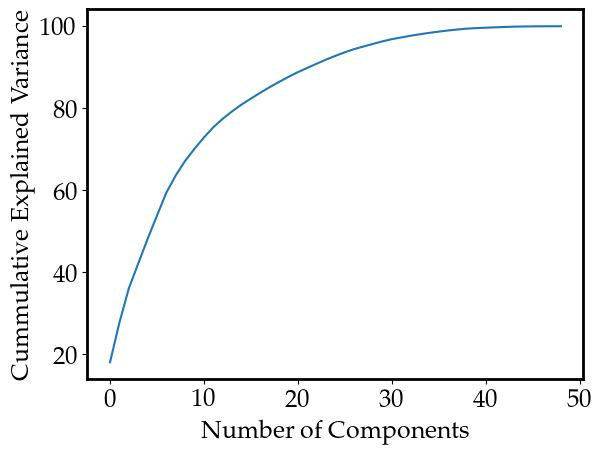

In [37]:
plt.plot(np.cumsum(pca.explained_variance_ratio_)*100)
plt.xlabel('Number of Components')
plt.ylabel('Cummulative Explained Variance')
plt.show()

In [38]:
def KL(feature1 ,feature2 , bins = 100, eps = 1e-8):
    low, high = (np.min([np.min(feature1),np.min(feature2)]), np.max([np.max(feature1),np.max(feature2)]))
    pk, bins = np.histogram(feature1, bins=bins, range=(low,high))
    qk, bins = np.histogram(feature2, bins=bins, range=(low,high))
    pk = pk + eps
    qk = qk + eps
    D1 = stats.entropy(pk, qk)
    D2 = stats.entropy(qk, pk)
    divergence = D1 + D2
    return divergence

In [39]:
div = []
for i in tqdm(features):
    divergence = KL(sig_train_out[i], bkg_train_out[i])
    div.append(divergence)
divergences = pd.Series(div, index=features).sort_values(ascending=False)
print(divergences)

  0%|          | 0/49 [00:00<?, ?it/s]

fj_mass                          2.601809
fj_ptDR                          2.337184
fj_tau21                         2.228238
fj_trackSip2dSigAboveBottom_0    1.404426
fj_sdsj2_mass                    1.395849
fj_trackSip2dSigAboveCharm_0     1.171646
fj_sdsj1_mass                    1.145754
fj_sdsj2_pt                      1.132133
fj_trackSip2dSigAboveBottom_1    1.076068
fj_sdn2                          1.045277
fj_pt                            0.992416
fj_tau_flightDistance2dSig_0     0.858293
fj_trackSipdSig_0                0.808269
fj_trackSipdSig_0_0              0.795845
fj_tau_vertexEnergyRatio_0       0.756656
fj_nSV                           0.705394
fj_sdsj1_pt                      0.699951
fj_tau_vertexDeltaR_0            0.606437
fj_trackSipdSig_0_1              0.596671
fj_tau_vertexEnergyRatio_1       0.595779
fj_trackSipdSig_1                0.586468
fj_sdsj2_ptD                     0.563832
fj_tau1                          0.557239
fj_trackSipdSig_2                0

In [40]:
# X_train_final = pd.DataFrame(pca.transform(X_train)).iloc[:,:20]
# X_test_final =  pd.DataFrame(pca.transform(X_test)).iloc[:,:20]
X_train_final = X_train
X_test_final =  X_test

In [44]:
def make_ks_plot(y_train, train_proba, y_test, test_proba, bins=30, fig_sz=(10, 8)):
    '''
    OUTPUT: outputs KS test/train overtraining plots for classifier output
    INPUTS:
        y_train - Series with outputs of model
        train_proba - np.ndarray from sklearn predict_proba(). Same shape as y_train. 0-1 probabilities from model.
        y_test - Series with outputs of model
        test_proba - np.ndarray from sklearn predict_proba(). Same shape as y_test. 0-1 probabilities from model.
        bins - number of bins for viz. Default 30.
        fig_sz - change to True in order to get larger outputs. Default False.
    '''

    train = pd.DataFrame(y_train, columns=["label"])
    test = pd.DataFrame(y_test, columns=["label"])
    train["probability"] = train_proba
    test["probability"] = test_proba
    
    decisions = []
    for df in [train, test]:
        d1 = df['probability'][df["label"] == 1]
        d2 = df['probability'][df["label"] == 0]
        decisions += [d1, d2]

    low = min(np.min(d) for d in decisions)
    high = max(np.max(d) for d in decisions)
    low_high = (0,1)

    fig = plt.figure(figsize=fig_sz)
    
    train_pos = plt.hist(decisions[0],
         color='b', alpha=0.5, range=low_high, bins=bins,
         histtype='stepfilled', density=True,
         label='Signal (test)')

    train_neg = plt.hist(decisions[1],
         color='r', alpha=0.5, range=low_high, bins=bins,
         histtype='stepfilled', density=True,
         label='Background (test)')

    hist, bins = np.histogram(decisions[2],
                          bins=bins, range=low_high, density=True)
    scale = len(decisions[2]) / sum(hist)
    err = np.sqrt(hist * scale) / scale

    width = (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    test_pos = plt.errorbar(center, hist, yerr=err, fmt='o', c='b', label='Signal (train)')

    hist, bins = np.histogram(decisions[3],
                          bins=bins, range=low_high, density=True)
    scale = len(decisions[2]) / sum(hist)
    err = np.sqrt(hist * scale) / scale

    test_neg = plt.errorbar(center, hist, yerr=err, fmt='o', c='r', label='Background (train)')

    # get the KS score
    ks = stats.ks_2samp(decisions[0], decisions[2])

    plt.xlabel("Classifier Output", fontsize=12)
    plt.ylabel("Arbitrary Normalized Units", fontsize=12)

    plt.xlim(0, 1)
    plt.plot([], [], ' ', label='KS Statistic (p-value): '+str(round(ks[0],3))+' ('+str(round(ks[1],3))+')')
    plt.legend(loc='upper center', fontsize=12)
    plt.tight_layout()
    plt.close()
    return fig

In [57]:
# build a simple neural network in keras

keras_model = keras.Sequential()
keras_model.add(BatchNormalization(input_shape=(X_train_final.shape[1],)))
keras_model.add(Dense(units=60,activation='relu',input_dim=X_train_final.shape[1]))
keras_model.add(Dense(units=60,activation='relu'))
keras_model.add(Dense(units=2,activation='softmax'))
keras_model.save_weights('random_weights.h5')
print(keras_model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_4 (Batc  (None, 49)               196       
 hNormalization)                                                 
                                                                 
 dense_12 (Dense)            (None, 60)                3000      
                                                                 
 dense_13 (Dense)            (None, 60)                3660      
                                                                 
 dense_14 (Dense)            (None, 2)                 122       
                                                                 
Total params: 6,978
Trainable params: 6,880
Non-trainable params: 98
_________________________________________________________________
None


In [53]:
losses = []
rates = np.logspace(-3,0,100)

for lr in tqdm(rates):
    keras_model.load_weights('random_weights.h5')
    opt = keras.optimizers.SGD(learning_rate=lr)
    keras_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    history = keras_model.fit(X_train_final.to_numpy(), y_train.to_numpy(), batch_size=2**16, epochs=10,
                              shuffle=False)
    losses.append(history.history['loss'][-1])

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/10
55/55 [==============================] - 2s 25ms/step - loss: 0.8337 - accuracy: 0.4794
Epoch 2/10
55/55 [==============================] - 1s 24ms/step - loss: 0.7682 - accuracy: 0.4912
Epoch 3/10
55/55 [==============================] - 1s 23ms/step - loss: 0.7226 - accuracy: 0.5184
Epoch 4/10
55/55 [==============================] - 1s 24ms/step - loss: 0.6886 - accuracy: 0.5530
Epoch 5/10
55/55 [==============================] - 1s 24ms/step - loss: 0.6617 - accuracy: 0.5883
Epoch 6/10
55/55 [==============================] - 1s 24ms/step - loss: 0.6393 - accuracy: 0.6202
Epoch 7/10
55/55 [==============================] - 1s 24ms/step - loss: 0.6201 - accuracy: 0.6479
Epoch 8/10
55/55 [==============================] - 1s 25ms/step - loss: 0.6032 - accuracy: 0.6714
Epoch 9/10
55/55 [==============================] - 1s 25ms/step - loss: 0.5882 - accuracy: 0.6913
Epoch 10/10
55/55 [==============================] - 1s 25ms/step - loss: 0.5746 - accuracy: 0.7077
Epoch 1/1

KeyboardInterrupt: 

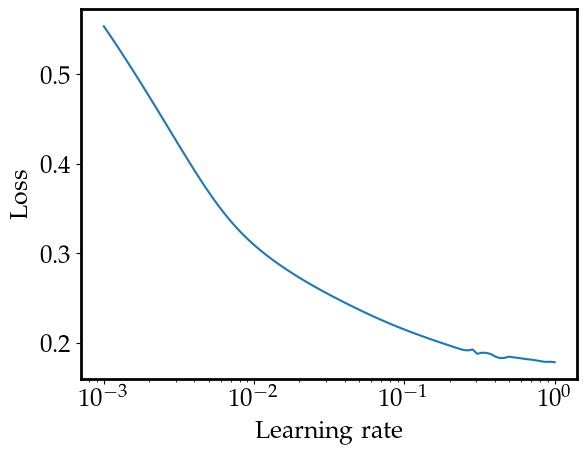

In [50]:
plt.plot(rates, losses)
plt.xlabel("Learning rate")
plt.ylabel("Loss")
plt.semilogx()
plt.show()

In [54]:
lr = rates[np.nanargmin(losses)]
print(lr)

0.0010722672220103231


In [58]:
%%time
# define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
model_checkpoint = ModelCheckpoint('keras_model_best.h5', monitor='val_loss', save_best_only=True)
callbacks = [early_stopping, model_checkpoint]

# fit keras model
keras_model.load_weights('random_weights.h5')
opt = keras.optimizers.SGD(learning_rate=lr)
keras_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
history = keras_model.fit(X_train_final.to_numpy(), y_train.to_numpy(), batch_size=2**16, 
                          epochs=100, shuffle=False, callbacks = callbacks, 
                          validation_data=(X_test_final,y_test))

Epoch 1/100
55/55 [==============================] - 2s 24ms/step - loss: 0.3264 - accuracy: 0.8603 - val_loss: 0.2280 - val_accuracy: 0.9065
Epoch 2/100
55/55 [==============================] - 1s 19ms/step - loss: 0.2259 - accuracy: 0.9067 - val_loss: 0.2071 - val_accuracy: 0.9157
Epoch 3/100
55/55 [==============================] - 1s 19ms/step - loss: 0.2108 - accuracy: 0.9134 - val_loss: 0.2163 - val_accuracy: 0.9106
Epoch 4/100
55/55 [==============================] - 1s 19ms/step - loss: 0.2016 - accuracy: 0.9177 - val_loss: 0.1932 - val_accuracy: 0.9222
Epoch 5/100
55/55 [==============================] - 1s 18ms/step - loss: 0.1944 - accuracy: 0.9209 - val_loss: 0.1975 - val_accuracy: 0.9199
Epoch 6/100
55/55 [==============================] - 1s 19ms/step - loss: 0.1897 - accuracy: 0.9232 - val_loss: 0.1840 - val_accuracy: 0.9262
Epoch 7/100
55/55 [==============================] - 1s 18ms/step - loss: 0.1862 - accuracy: 0.9248 - val_loss: 0.1900 - val_accuracy: 0.9234
Epoch 

55/55 [==============================] - 1s 21ms/step - loss: 0.1562 - accuracy: 0.9380 - val_loss: 0.1554 - val_accuracy: 0.9388
Epoch 59/100
55/55 [==============================] - 1s 18ms/step - loss: 0.1568 - accuracy: 0.9377 - val_loss: 0.1594 - val_accuracy: 0.9371
Epoch 60/100
55/55 [==============================] - 1s 19ms/step - loss: 0.1559 - accuracy: 0.9381 - val_loss: 0.1551 - val_accuracy: 0.9389
Epoch 61/100
55/55 [==============================] - 1s 20ms/step - loss: 0.1566 - accuracy: 0.9378 - val_loss: 0.1592 - val_accuracy: 0.9371
Epoch 62/100
55/55 [==============================] - 1s 18ms/step - loss: 0.1555 - accuracy: 0.9383 - val_loss: 0.1549 - val_accuracy: 0.9390
Epoch 63/100
55/55 [==============================] - 1s 18ms/step - loss: 0.1563 - accuracy: 0.9379 - val_loss: 0.1590 - val_accuracy: 0.9373
Epoch 64/100
55/55 [==============================] - 1s 18ms/step - loss: 0.1553 - accuracy: 0.9383 - val_loss: 0.1547 - val_accuracy: 0.9390
Epoch 65/100

In [59]:
# reload best weights
keras_model.load_weights('keras_model_best.h5')

In [60]:
# run model inference on test data set
predict_array_train = keras_model.predict(X_train_final)
predict_array_test = keras_model.predict(X_test_final)

13921/13921 [==============================] - 4s 287us/step


In [61]:
# create ROC curve
fpr, tpr, threshold = roc_curve(y_test.to_numpy()[:,0], predict_array_test[:,0])

In [62]:
print(keras_model.evaluate(X_train_final,y_train))
print(keras_model.evaluate(X_test_final,y_test))

111433/111433 [==============================] - 41s 367us/step - loss: 0.1490 - accuracy: 0.9410
[0.14898480474948883, 0.9410288333892822]
13921/13921 [==============================] - 5s 367us/step - loss: 0.1510 - accuracy: 0.9407
[0.1510068029165268, 0.9407269954681396]


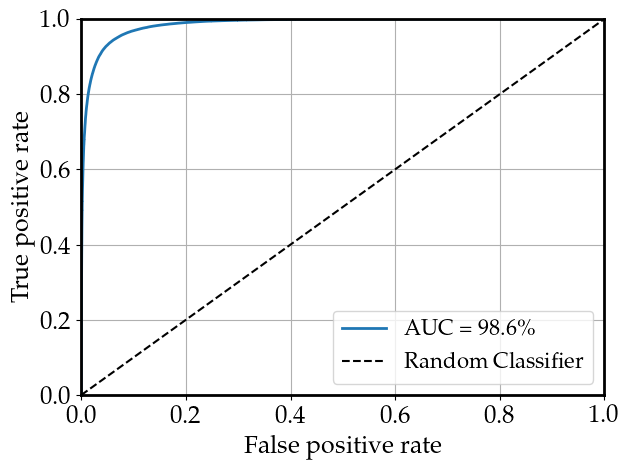

In [63]:
# plot ROC curve
plt.figure()
plt.plot(fpr, tpr, lw=2, label=f"AUC = {auc(fpr,tpr)*100:.1f}\%")
plt.plot(np.linspace(0,1),np.linspace(0,1),color='k',ls='--',label = 'Random Classifier')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.ylim(0,1)
plt.xlim(0,1)
plt.grid()
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig('plots/ROC_MLP_combined.pdf')
plt.show()

In [64]:
fig = make_ks_plot(y_train.to_numpy()[:,0], predict_array_train[:,0],
                   y_test.to_numpy()[:,0], predict_array_test[:,0])
fig.savefig('plots/KS_MLP_combined.pdf')

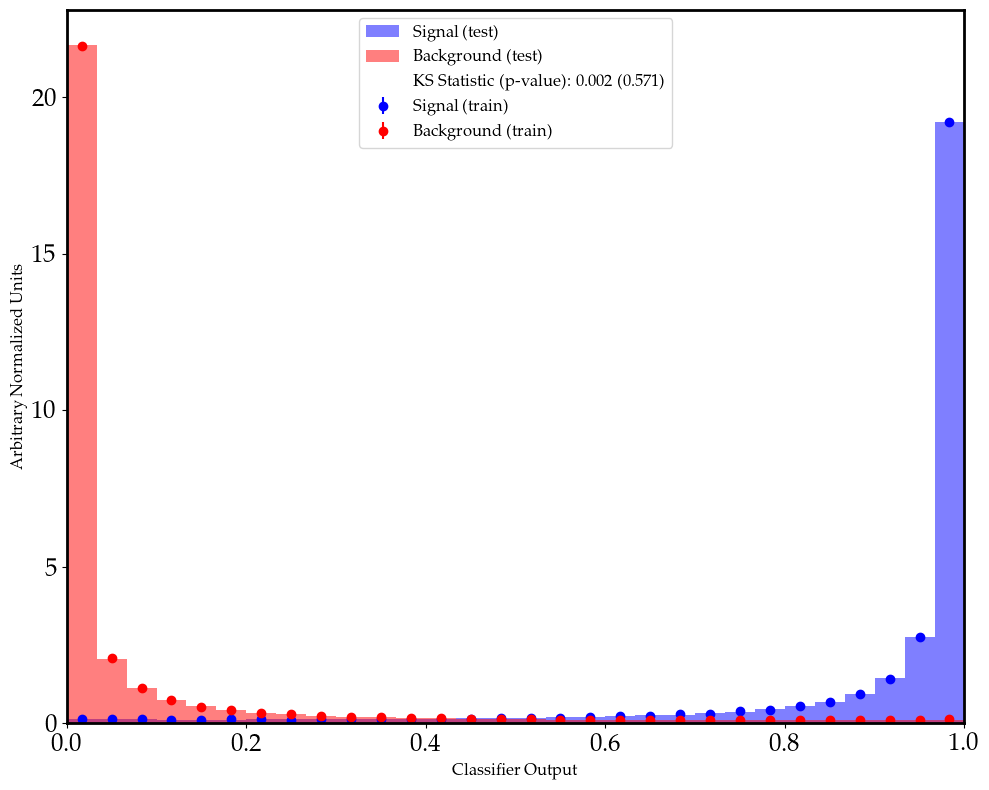

In [65]:
fig

In [66]:
bdt = XGBClassifier(booster='gbtree')

In [67]:
%%time
bdt.fit(X_train_final.to_numpy(), y_train.to_numpy())

CPU times: user 1h 43min 58s, sys: 54.8 s, total: 1h 44min 53s
Wall time: 10min 57s


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [68]:
print(bdt.score(X_train_final.to_numpy(), y_train.to_numpy()))
print(bdt.score(X_test_final.to_numpy(), y_test.to_numpy()))

0.9454404112819863
0.9434544654562433


In [69]:
predict_array_train = bdt.predict_proba(X_train_final)
predict_array_test = bdt.predict_proba(X_test_final)
fpr, tpr, threshold = roc_curve(y_test.to_numpy()[:,0], predict_array_test[:,0])

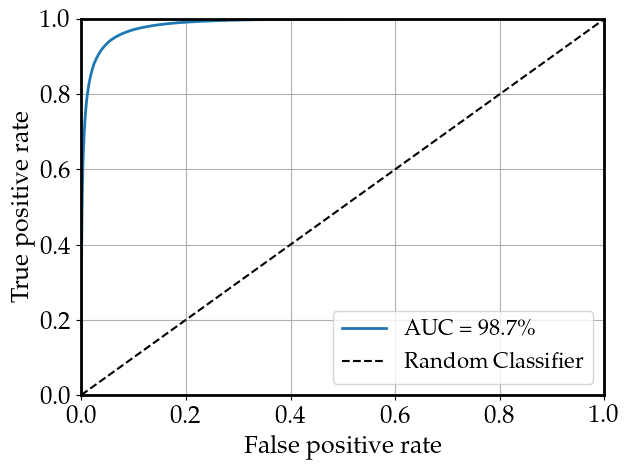

In [70]:
plt.figure()
plt.plot(fpr, tpr, lw=2, label=f"AUC = {auc(fpr,tpr)*100:.1f}\%")
plt.plot(np.linspace(0,1),np.linspace(0,1),color='k',ls='--',label = 'Random Classifier')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.ylim(0,1)
plt.xlim(0,1)
plt.grid()
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig('plots/ROC_BDT_combined.pdf')
plt.show()

In [71]:
fig = make_ks_plot(y_train.to_numpy()[:,0], predict_array_train[:,0],
                   y_test.to_numpy()[:,0], predict_array_test[:,0])
fig.savefig('plots/KS_BDT_combined.pdf')

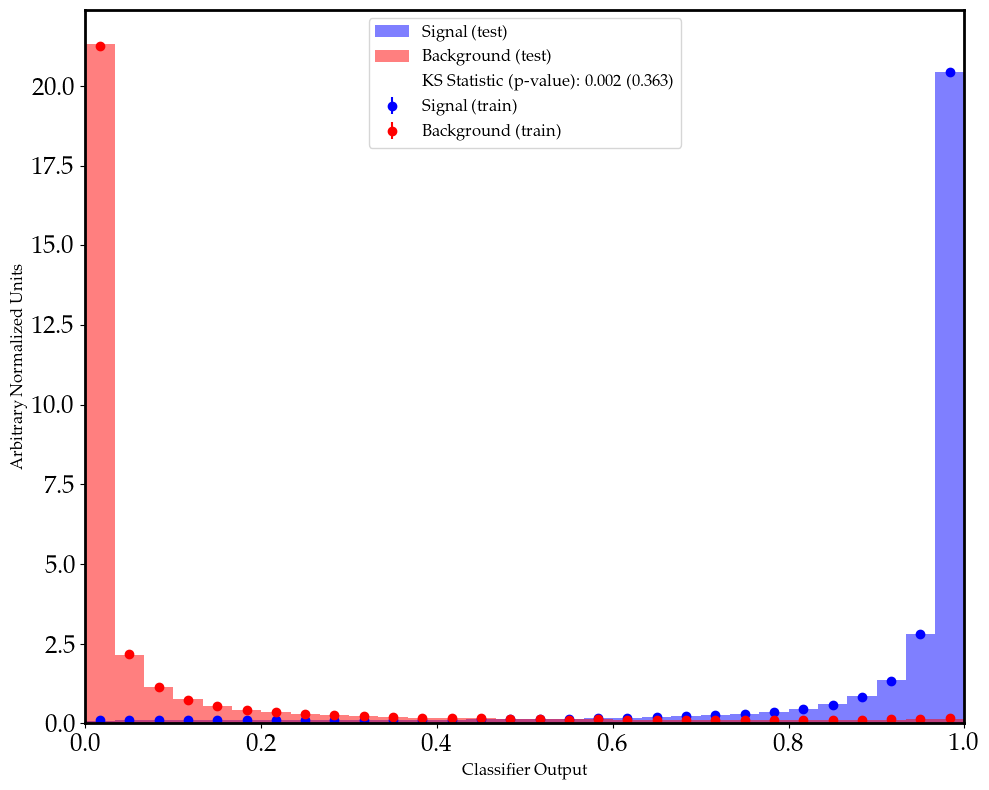

In [72]:
fig

In [73]:
fisher = LinearDiscriminantAnalysis()

In [74]:
%%time
fisher.fit(X_train_final.to_numpy(), y_train.to_numpy()[:,0])

CPU times: user 28.5 s, sys: 4.39 s, total: 32.9 s
Wall time: 14.5 s


LinearDiscriminantAnalysis()

In [75]:
print(fisher.score(X_train_final.to_numpy(), y_train.to_numpy()[:,0]))
print(fisher.score(X_test_final.to_numpy(), y_test.to_numpy()[:,0]))

0.8585281502799071
0.8586664691198391


In [76]:
predict_array_train = fisher.predict_proba(X_train_final)
predict_array_test = fisher.predict_proba(X_test_final)
fpr, tpr, threshold = roc_curve(y_test.to_numpy()[:,0], predict_array_test[:,1])

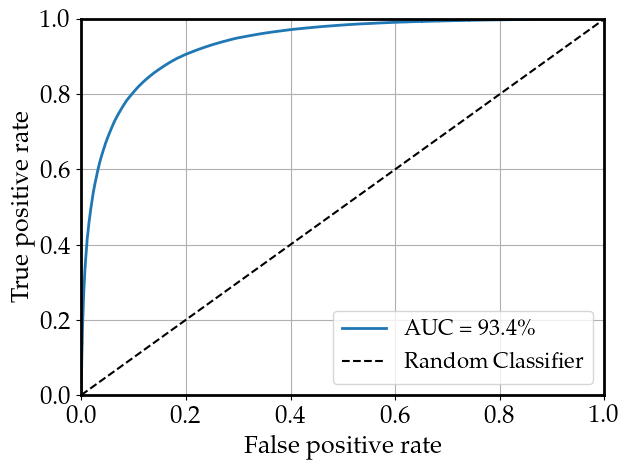

In [77]:
plt.figure()
plt.plot(fpr, tpr, lw=2, label=f"AUC = {auc(fpr,tpr)*100:.1f}\%")
plt.plot(np.linspace(0,1),np.linspace(0,1),color='k',ls='--',label = 'Random Classifier')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.ylim(0,1)
plt.xlim(0,1)
plt.grid()
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig('plots/ROC_LDA_combined.pdf')
plt.show()

In [78]:
fig = make_ks_plot(y_train.to_numpy()[:,0], predict_array_train[:,1],
                   y_test.to_numpy()[:,0], predict_array_test[:,1])
fig.savefig('plots/KS_LDA_combined.pdf')

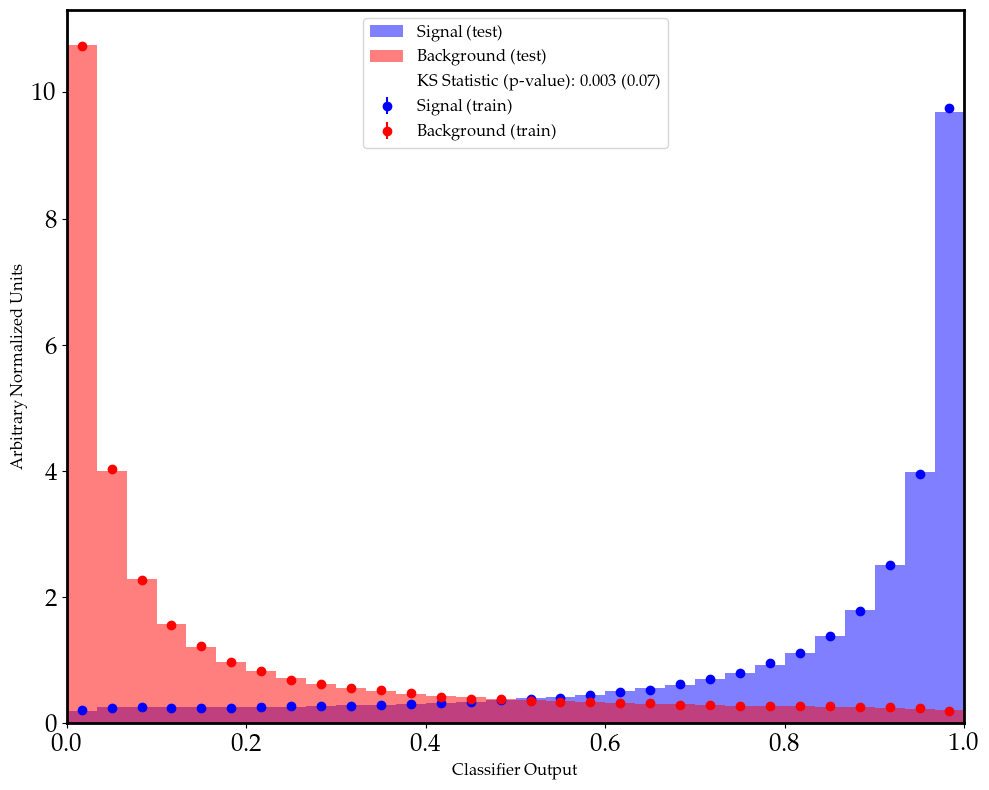

In [79]:
fig